# Combined Fire and Beetle Disturbance Analysis in Western US Forests

This notebook processes forest disturbance data across the Western United States to identify areas impacted by both fire and beetle infestations over time. The workflow involves reading forest disturbance data for each year, isolating areas affected by both beetle and fire disturbances, and generating raster files to track the intersection of these two disturbance types.

The analysis includes:
- Identifying regions impacted by both beetles and fire by processing annual forest disturbance raster data.
- Aggregating beetle and fire presence data over five-year periods to track regions experiencing both disturbance types within the same time window.
- Summarizing the total area affected by both beetles and fire over five-year intervals and visualizing these trends with a plot.

The output includes:
- Geospatial raster files showing combined beetle and fire presence per year.
- Five-year aggregated raster files showing the total number of years impacted by both beetles and fire.
- A plot visualizing the total area affected by both beetles and fire over five-year periods.

This analysis helps explore the interaction between fire and beetle disturbances in Western US forests.

In [1]:
# Import packages
import os
from glob import glob
import earthpy as et
from os import path
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import gc

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

forest_folder = path.join(home, "forest-disturbance-stack", "western-conus")
combine_folder = path.join(home, "forest-disturbance-stack", "combined-western-conus")
fiveyear_fire_beetle_folder = path.join(home, "forest-disturbance-stack", "five-year-fire-beetle")

In [9]:
# Loop through each year of forest disturbances for a 5 year period and calculate where both beetle and fire disturbances were present
forest_tif_list = sorted(glob(path.join(forest_folder, "forest-disturbance-stack_western-conus_*.tif")))
for tif in forest_tif_list:
    year = tif[-8:-4]
    print(year)
    with rio.open(tif) as src:
        array = src.read(1)
        meta = src.profile
    array[array == 1] = 1
    array[array == 5] = 1
    array[array == 9] = 1
    array[array == 13] = 1
    array[array == 2] = 1
    array[array == 6] = 1
    array[array == 10] = 1
    array[array == 14] = 1
    array[array != 1] = 0
    with rio.open(path.join(combine_folder, "fire_beetle_presence_{}.tif".format(year)), 'w', **meta) as dst:
        dst.write(array, 1)

1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [11]:
# Find all areas that had more than one fire and/or beetle disturbance in each time period
fire_tif_list = sorted(glob(path.join(combine_folder, "fire_beetle_presence_*.tif")))
year_totals_over_2 = {}

for i, tif in enumerate(fire_tif_list):
    if i >=4:
        years = fire_tif_list[i-4:i+1]
        start_year = years[0][-8:-4]
        end_year = years[4][-8:-4]
        print("Processing years {} to {}".format(start_year, end_year))
        with rio.open(years[0]) as src:
            years_array = src.read(1)
            meta = src.profile
        for year in years[1:]:
            with rio.open(year) as src:
                array = src.read(1)
            years_array += array
            del(array)
            gc.collect()
        with rio.open(path.join(fiveyear_fire_beetle_folder, "fire_beetle_totals_{}-.{}.tif".format(start_year, end_year)), 'w', **meta) as dst:
            dst.write(years_array, 1)
        years_array[years_array <= 1] = 0
        years_array[years_array > 1] = 1
        year_totals_over_2[end_year] = (years_array.sum()* 30 * 30)/1000000    
        del(years_array)
        gc.collect()

Processing years 1999 to 2003
Processing years 2000 to 2004
Processing years 2001 to 2005
Processing years 2002 to 2006
Processing years 2003 to 2007
Processing years 2004 to 2008
Processing years 2005 to 2009
Processing years 2006 to 2010
Processing years 2007 to 2011
Processing years 2008 to 2012
Processing years 2009 to 2013
Processing years 2010 to 2014
Processing years 2011 to 2015
Processing years 2012 to 2016
Processing years 2013 to 2017
Processing years 2014 to 2018
Processing years 2015 to 2019
Processing years 2016 to 2020


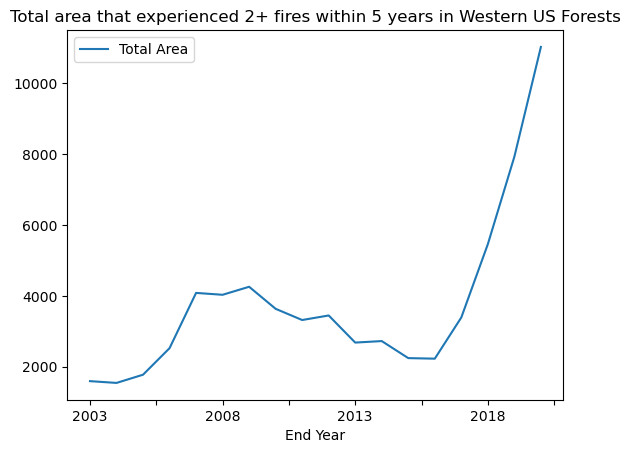

In [16]:
# Rearrange and plot the data

years = list(year_totals_over_2.keys())
area = list(year_totals_over_2.values())
data = {'End Year': years, 'Total Area': area}
short_term_plot = pd.DataFrame(data)

fig, ax = plt.subplots()
short_term_plot.plot('End Year',
                    y='Total Area', 
                    title='Total area that experienced 2+ fires within 5 years in Western US Forests',
                    ax=ax)
plt.savefig(os.path.join(fiveyear_fire_beetle_folder, "fiveyear_fire_beetle.png"))
plt.show()

In [14]:
short_term_plot.to_csv(os.path.join(fiveyear_fire_beetle_folder, 'fire_beetle_area_over_time.csv'))